In [74]:
import os
import sys
import time

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T

cuda


In [75]:
model_dir = os.getcwd() + '/Models/'
image_dir = os.getcwd() + '/Images/'
output_dir = os.getcwd() + '/Output/'

In [76]:
# FCN model
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
model.eval()

Using cache found in C:\Users\MSI-NB/.cache\torch\hub\pytorch_vision_v0.10.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [77]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [78]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [79]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
prep_but_better = transforms.Compose([transforms.Resize(img_size)])

postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [80]:
def run_transfer(style_name,
                 content_name,
                 output_name="output",
                 output_dir=output_dir,
                 pool_method="avg",
                 style_layers=['r11','r21','r31','r41','r51'],
                 mask_layers=['r42'],
                 content_layers=['r42'],
                 style_weight=5e3,
                 content_weight=5e0,
                 mask_weight=45,
                 style_layer_weights=[64,128,256,512,512],
                 max_iter=1000,
                 show_iter=50,
                 output_metrics=True):

    # set up time and loss trackers
    start_time = time.time()
    times = []
    losses = []

    #get network
    vgg = VGG(pool=pool_method)
    vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
    for param in vgg.parameters():
        param.requires_grad = False
    if torch.cuda.is_available():
        vgg.cuda()

    #load images, ordered as [style_image, content_image]
    img_dirs = [image_dir, image_dir]
    img_names = [style_name, content_name]
    imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
    input_image = imgs[1]
    input_image=prep_but_better(input_image)
    input_image = input_image.convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]

    # Exponetial the negative
    output_bg = torch.exp(output)[0]
    output_class_sum = torch.sum(torch.exp(output), 0)
    output_bg_div = output_bg / output_class_sum
    output_predictions = 1 - output_bg_div

    # get masked image
    H, W = output_predictions.size()
    mask_np_3 = torch.zeros((3, H, W)).cuda()
    for n in range(3):
        mask_np_3[n, :, :] = output_predictions
    content_img = prep_but_better(imgs[1])
    transform = transforms.Compose([transforms.ToTensor()])
    content_img_tensor = transform(content_img).cuda()
    mask_img_np = torch.mul(content_img_tensor, mask_np_3).cuda()

    def filter_with_mask(input):
        out = torch.mul(input, mask_np_3.unsqueeze(0).cuda()).cuda()
        return out

    # plot the semantic segmentation predictions of 21 classes
    transform = transforms.ToPILImage()
    r_bg = transform(mask_img_np)
    imgs.append(r_bg)

    #initialize the output image
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image, content_masked_image = imgs_torch

    opt_img = Variable(content_image.data.clone(), requires_grad=True)

    #define layers, loss functions, weights and compute optimization targets
    loss_layers_gatys =  style_layers + content_layers
    loss_layers_mask = mask_layers
    loss_fns_gatys = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    loss_fns_mask = [nn.MSELoss()] * len(mask_layers) 
    if torch.cuda.is_available():
        loss_fns_gatys = [loss_fn.cuda() for loss_fn in loss_fns_gatys]
        loss_fns_mask = [loss_fn.cuda() for loss_fn in loss_fns_mask]
        
    #these are good weights settings:
    mask_weights = [mask_weight] # Increase weights actually blurs background
    style_weights = [style_weight/n**2 for n in style_layer_weights]
    content_weights = [content_weight]

    weights_mask = mask_weights 
    weights_gatys = style_weights + content_weights

    #compute optimization targets
    mask_targets = [A.detach() for A in vgg(content_masked_image, content_layers)]
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
    content_targets = [A.detach() for A in vgg(content_image, content_layers)]
    targets_gatys = style_targets + content_targets
    targets_mask = mask_targets 

    #run style transfer
    optimizer = optim.LBFGS([opt_img])
    n_iter = [0]

    times.append(time.time()-start_time)
    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out_gatys = vgg(opt_img, loss_layers_gatys)
            out_mask = vgg(filter_with_mask(opt_img), loss_layers_mask)
            layer_losses_gatys = [weights_gatys[a] * loss_fns_gatys[a](A, targets_gatys[a]) for a,A in enumerate(out_gatys)]
            layer_losses_mask = [weights_mask[a] * loss_fns_mask[a](A, targets_mask[a]) for a,A in enumerate(out_mask)]
            loss = torch.stack(layer_losses_gatys, dim=0).sum(dim=0)+torch.stack(layer_losses_mask,dim=0).sum(dim=0)
            loss.backward()
            n_iter[0] += 1
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
                losses.append(loss.item())
                times.append(time.time()-start_time)
            return loss
        
        optimizer.step(closure)
        
    #save output image and return metrics
    out_img = postp(opt_img.data[0].cpu().squeeze())
    out_img.save(output_dir + output_name + ".png")
    if output_metrics: return losses, times

In [81]:
content_images = ["Content/10.png" for _ in range(10)]
style_images = ["Style/01.png", "Style/02.png", "Style/03.png", "Style/04.png", "Style/05.png", 
                "Style/06.png", "Style/07.png", "Style/08.png", "Style/09.png", "Style/10.png"]

In [82]:
# actual thing
losses, times = list(), list()
for i in range(len(content_images)):
    l,t = run_transfer(style_name = style_images[i], 
                       content_name = content_images[i],
                       max_iter = 2000,
                       output_name = "s" + style_images[i][6:8] + "_mask_better",
                       output_dir = output_dir + "portait_aware_10/",
                       output_metrics = True)
    losses.append(l)
    times.append(t)

Iteration: 50, loss: 2802237.750000
Iteration: 50, loss: 2726725.500000
Iteration: 50, loss: 4620025.000000
Iteration: 50, loss: 3820059.250000
Iteration: 50, loss: 2799000.000000
Iteration: 50, loss: 2888769.250000
Iteration: 50, loss: 2835441.000000
Iteration: 50, loss: 2964136.250000
Iteration: 50, loss: 2958258.250000
Iteration: 50, loss: 7263855.000000


In [83]:
losses = np.array(losses)
times = np.array(times)

np.savetxt(output_dir+"portrait_mask_best_losses.csv", losses, delimiter=",")
np.savetxt(output_dir+"portrait_mask_best_times.csv", times, delimiter=",")

In [77]:
portrait_naive_losses = np.genfromtxt(output_dir+"portrait_naive_losses.csv", delimiter=",")
portrait_naive_times = np.genfromtxt(output_dir+"portrait_naive_times.csv", delimiter=",")
portrait_naive_times = np.hstack((np.zeros((10,1)), portrait_naive_times))

portrait_weight_losses = np.genfromtxt(output_dir+"portrait_weight_losses.csv", delimiter=",")
portrait_weight_times = np.genfromtxt(output_dir+"portrait_weight_times.csv", delimiter=",")
portrait_weight_times = np.hstack((np.zeros((10,1)), portrait_weight_times))

portrait_reuse_style_losses = np.genfromtxt(output_dir+"portrait_reuse_style_losses.csv", delimiter=",")
portrait_reuse_style_times = np.genfromtxt(output_dir+"portrait_reuse_style_times.csv", delimiter=",")
portrait_reuse_style_times = np.hstack((np.zeros((10,1)), portrait_reuse_style_times))

portrait_reuse_content_losses = np.genfromtxt(output_dir+"portrait_reuse_content_losses.csv", delimiter=",")
portrait_reuse_content_times = np.genfromtxt(output_dir+"portrait_reuse_content_times.csv", delimiter=",")
portrait_reuse_content_times = np.hstack((np.zeros((10,1)), portrait_reuse_content_times))

portrait_align_losses = np.genfromtxt(output_dir+"portrait_align_losses.csv", delimiter=",")
portrait_align_times = np.genfromtxt(output_dir+"portrait_align_times.csv", delimiter=",")
portrait_align_times = np.hstack((np.zeros((10,1)), portrait_align_times))

portrait_mask_naive_losses = np.genfromtxt(output_dir+"portrait_mask_naive_losses.csv", delimiter=",")
portrait_mask_naive_times = np.genfromtxt(output_dir+"portrait_mask_naive_times.csv", delimiter=",")
portrait_mask_naive_times = np.hstack((np.zeros((9,1)), portrait_mask_naive_times))

portrait_mask_best_losses = np.genfromtxt(output_dir+"portrait_mask_best_losses.csv", delimiter=",")
portrait_mask_best_times = np.genfromtxt(output_dir+"portrait_mask_best_times.csv", delimiter=",")
portrait_mask_best_times = np.hstack((np.zeros((10,1)), portrait_mask_best_times))

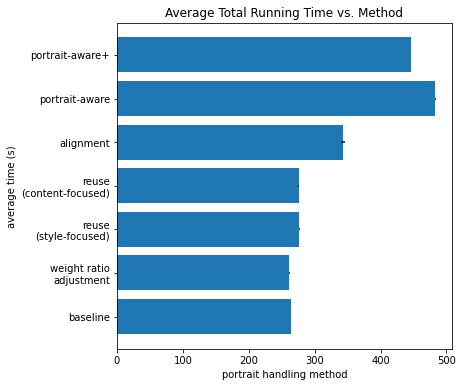

In [78]:
# plot total running time
plt.figure(figsize=[6,6])
plt.barh(y = ["baseline", "weight ratio\nadjustment",
              "reuse\n(style-focused)", "reuse\n(content-focused)", 
              "alignment", "portrait-aware", "portrait-aware+"],
         width = [portrait_naive_times[:,-1].mean(),
                  portrait_weight_times[:,-1].mean(),
                  portrait_reuse_style_times[:,-1].mean(),
                  portrait_reuse_content_times[:,-1].mean(),
                  portrait_align_times[:,-1].mean(),
                  portrait_mask_naive_times[:,-1].mean(),
                  portrait_mask_best_times[:,-1].mean()],
         xerr = [np.std(portrait_naive_times[:,-1]) / np.sqrt(portrait_naive_times.shape[0]),
                 np.std(portrait_weight_times[:,-1]) / np.sqrt(portrait_weight_times.shape[0]),
                 np.std(portrait_reuse_style_times[:,-1]) / np.sqrt(portrait_reuse_style_times.shape[0]),
                 np.std(portrait_reuse_content_times[:,-1]) / np.sqrt(portrait_reuse_content_times.shape[0]),
                 np.std(portrait_align_times[:,-1]) / np.sqrt(portrait_align_times.shape[0]),
                 np.std(portrait_mask_naive_times[:,-1]) / np.sqrt(portrait_mask_naive_times.shape[0]),
                 np.std(portrait_mask_best_times[:,-1]) / np.sqrt(portrait_mask_best_times.shape[0])])
plt.xlabel("portrait handling method")
plt.ylabel("average time (s)")
plt.title("Average Total Running Time vs. Method")
plt.draw()
plt.ioff()
plt.show()

In [79]:
print(portrait_naive_times[:,-1].mean())
print(portrait_weight_times[:,-1].mean())
print(portrait_reuse_style_times[:,-1].mean())
print(portrait_reuse_content_times[:,-1].mean())
print(portrait_align_times[:,-1].mean())
print(portrait_mask_naive_times[:,-1].mean())
print(portrait_mask_best_times[:,-1].mean())

264.18794231414796
261.4868272066116
276.93479347229004
275.68687279224395
343.467586016655
483.07115409109326
445.8683789253235


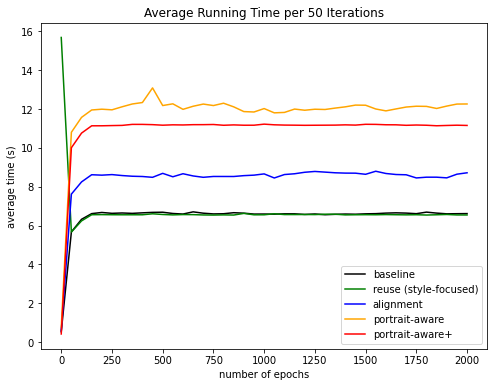

In [81]:
# plot per-50-iterations running time
plt.figure(figsize=[8,6])
plt.plot(range(0, 2001, 50), np.diff(portrait_naive_times[:,:], axis=1).mean(axis=0), color = "black")
plt.plot(range(0, 2001, 50), np.diff(portrait_reuse_style_times[:,:], axis=1).mean(axis=0), color = "green")
plt.plot(range(0, 2001, 50), np.diff(portrait_align_times[:,:], axis=1).mean(axis=0), color = "blue")
plt.plot(range(0, 2001, 50), np.diff(portrait_mask_naive_times[:,:], axis=1).mean(axis=0), color = "orange")
plt.plot(range(0, 2001, 50), np.diff(portrait_mask_best_times[:,:], axis=1).mean(axis=0), color = "red")
plt.legend(labels = ["baseline", "reuse (style-focused)", "alignment",
                     "portrait-aware", "portrait-aware+"],
           loc = "lower right")
plt.xlabel("number of epochs")
plt.ylabel("average time (s)")
plt.title("Average Running Time per 50 Iterations")
plt.draw()
plt.ioff()
plt.show()

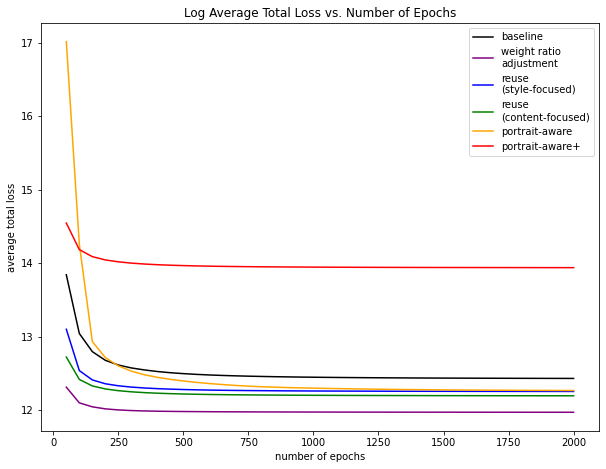

In [70]:
plt.figure(figsize=[10,7.5])
plt.plot(range(50, 2001, 50), np.log(portrait_naive_losses.mean(axis=0)), color = "black")
plt.plot(range(50, 2001, 50), np.log(portrait_weight_losses.mean(axis=0)), color = "purple")
plt.plot(range(50, 2001, 50), np.log(portrait_reuse_style_losses.mean(axis=0)), color = "blue")
plt.plot(range(50, 2001, 50), np.log(portrait_reuse_content_losses.mean(axis=0)), color = "green")
plt.plot(range(50, 2001, 50), np.log(portrait_align_losses.mean(axis=0)), color = "pink")
plt.plot(range(50, 2001, 50), np.log(portrait_mask_naive_losses.mean(axis=0)), color = "orange")
plt.plot(range(50, 2001, 50), np.log(portrait_mask_best_losses.mean(axis=0)), color = "red")
plt.legend(labels = ["baseline", "weight ratio\nadjustment",
                     "reuse\n(style-focused)", "reuse\n(content-focused)", 
                     "portrait-aware", "portrait-aware+"],
           loc = "upper right")
plt.xlabel("number of epochs")
plt.ylabel("average total loss")
plt.title("Log Average Total Loss vs. Number of Epochs")
plt.draw()
plt.ioff()
plt.show()